In [23]:
import aux_tools
from aux_tools import save_fig

In [2]:
# Load serialized dataframe

import pickle
import pandas as pd

# [86400, 21600, 7200, 3600, 900]

file = "df_900_0.3_v3.raw"

df = pickle.load(open(file, 'rb'))  # type: pd.DataFrame

#encode window
df['relative_day_position'] = df['relative_day_position'].apply(lambda x: int((x*24)/285)  )

#remove zeros
df = df[df['packet_count:mean'] != 0]

In [4]:
# Pipeline

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

num_attribs = list(df.drop("entity", axis=1))  # numerical attributes

# numerical and categorical pipelines
num_pipeline = Pipeline([
    #('imputer', Imputer(strategy="median")),
    #('attribs_adder', CombinedAttributesAdder()),
    ('selector', aux_tools.DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler()),
    #('robust_scaler', RobustScaler()),
])

sliding_window_pipeline = Pipeline([
    ('selector', aux_tools.DataFrameSelector('relative_day_position')),
    ('revel', aux_tools.DataFrameRevel()),
    ('cat_encoder', aux_tools.CategoricalEncoder(encoding="onehot-dense")),
])


In [15]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("sliding_window_pipeline", sliding_window_pipeline),
])

In [16]:
from sklearn.utils import shuffle

df = shuffle(df)

fulldata = full_pipeline.fit_transform(df)
cat_encoder = aux_tools.CategoricalEncoder(encoding="ordinal")
fulldata_labels = df['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)

In [18]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

svm_clf = svm.LinearSVC(C=1.0, 
                        class_weight=None,
                        dual=True, 
                        fit_intercept=True,
                        intercept_scaling=1,
                        loss='hinge',
                        max_iter=5000,
                        multi_class='ovr',
                        penalty='l2',
                        random_state=None,
                        tol=0.0001,
                        verbose=0)


scores = cross_val_score(svm_clf,
                         fulldata,
                         fulldata_labels_ordinal.ravel()
                         #scoring='accuracy'
                        )

print("Accuracy: %0.2f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.98 (+/- 0.0043)


In [27]:
import os
def save_fig(fig_id, tight_layout=True, fig_extension="pdf", resolution=300):
    path = os.path.join(os.getcwd(), fig_id + "." + fig_extension)
    print(f"Saving figure {fig_id} to {path}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Automatically created module for IPython interactive environment
Normalized confusion matrix
[[9.99e-01 0.00e+00 3.36e-04 0.00e+00 2.24e-04 0.00e+00]
 [0.00e+00 9.95e-01 3.65e-03 7.06e-04 2.35e-04 4.71e-04]
 [1.58e-03 1.56e-02 9.68e-01 7.38e-03 4.48e-03 2.90e-03]
 [0.00e+00 0.00e+00 0.00e+00 9.59e-01 4.09e-02 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 5.13e-02 9.49e-01 1.57e-04]
 [3.35e-04 3.01e-03 2.68e-03 6.70e-04 6.70e-04 9.93e-01]]
Saving figure conf_mat to /home/luminoso/thesis/gjc-ml-2018abr_final/conf_mat.pdf
Normalized confusion matrix
[[0.   0.   0.6  0.   0.4  0.  ]
 [0.   0.   0.72 0.14 0.05 0.09]
 [0.05 0.49 0.   0.23 0.14 0.09]
 [0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   1.   0.   0.  ]
 [0.05 0.41 0.36 0.09 0.09 0.  ]]
Saving figure conf_mat_errors to /home/luminoso/thesis/gjc-ml-2018abr_final/conf_mat_errors.pdf


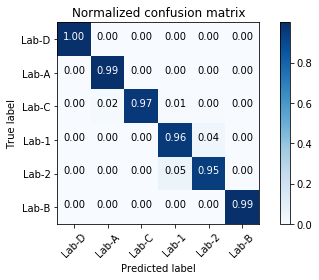

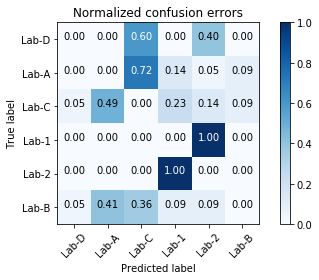

In [28]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

X = fulldata
y = fulldata_labels_ordinal.ravel()


class_names = [aux_tools.labnames[x] for x in list(cat_encoder.categories_[0])]


# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.LinearSVC(loss='hinge', max_iter=5000, C=1)
classifier.fit(X, y)

y_pred = cross_val_predict(classifier, X, y, cv=3)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

save_fig('conf_mat')


plt.figure()

row_sums = cnf_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = cnf_matrix / row_sums
np.fill_diagonal(norm_conf_mx, 0)

plot_confusion_matrix(norm_conf_mx, classes=class_names, normalize=True,
                      title='Normalized confusion errors')

save_fig('conf_mat_errors')

plt.show()

In [29]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(fulldata)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Saving figure pca_variance_095 to /home/luminoso/thesis/gjc-ml-2018abr_final/pca_variance_095.pdf


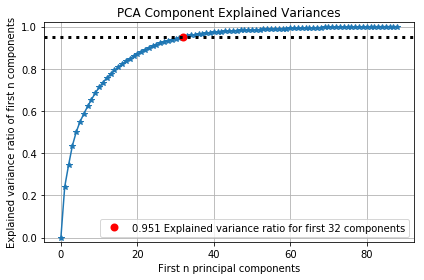

In [30]:
import scikitplot as skplt

skplt.decomposition.plot_pca_component_variance(pca,target_explained_variance=0.95)
save_fig('pca_variance_095')
plt.show()
